In [1]:
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import numpy as np
from torchvision.transforms import functional as F
from torch.utils.data import random_split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [2]:

class VOCSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, target_transform=None, colormap=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.target_transform = target_transform
        self.colormap = colormap
        self.images = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
        self.masks = [f.replace('.jpg', '.png') for f in self.images]
        self.images = [f for f in self.images if os.path.exists(os.path.join(mask_dir, f.replace('.jpg', '.png')))]

    def __len__(self):
        return len(self.images)

    def convert_to_segmentation_mask(self, mask):
        mask_array = np.array(mask, dtype=np.int32)
        label_mask = np.zeros((mask_array.shape[0], mask_array.shape[1]), dtype=np.int32)
        for label_index, label in enumerate(self.colormap):
            matches = np.all(mask_array == label, axis=-1)
            label_mask[matches] = label_index
        return label_mask

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.image_dir, img_name)
        mask_path = os.path.join(self.mask_dir, img_name.replace('.jpg', '.png'))

        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        #mask = F.resize(mask, (256, 256), interpolation=Image.NEAREST)
        mask = mask.resize((256, 256), Image.NEAREST)
        mask = self.convert_to_segmentation_mask(mask)  # This will be a 2D array
        mask = torch.tensor(mask, dtype=torch.long)  # Convert directly to tensor
        image = transforms.ToTensor()(image)

        return image, mask


# Define the colormap
VOC_COLORMAP = [
    [0, 0, 0],
    [128, 0, 0],
    [0, 128, 0],
    [128, 128, 0],
    [0, 0, 128],
    [128, 0, 128],
    [0, 128, 128],
    [128, 128, 128],
    [64, 0, 0],
    [192, 0, 0],
    [64, 128, 0],
    [192, 128, 0],
    [64, 0, 128],
    [192, 0, 128],
    [64, 128, 128],
    [192, 128, 128],
    [0, 64, 0],
    [128, 64, 0],
    [0, 192, 0],
    [128, 192, 0],
    [0, 64, 128],
]

train_transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=Image.BICUBIC),
    transforms.RandomHorizontalFlip()
])
val_transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=Image.BICUBIC),
])


image_dir = 'VOCdevkit/VOC2012/JPEGImages'
mask_dir = 'VOCdevkit/VOC2012/SegmentationClass'
dataset = VOCSegmentationDataset(image_dir, mask_dir, transform=None, colormap=VOC_COLORMAP)

val_size = 0.2
num_val_samples = int(val_size * len(dataset))
num_train_samples = len(dataset) - num_val_samples

train_dataset, val_dataset = random_split(dataset, [num_train_samples, num_val_samples])

train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_transform

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [3]:
class UNet(nn.Module):
    def __init__(self, num_classes=21):
        super(UNet, self).__init__()
        
        self.encoder1 = self.conv_block(3, 32) 
        self.encoder2 = self.conv_block(32, 64)
        self.encoder3 = self.conv_block(64, 128)
        self.encoder4 = self.conv_block(128, 256)
        self.down = nn.MaxPool2d(2)

        
        # Bottleneck
        self.bottleneck = self.conv_block(256, 512)

        # Decoder (Upsampling and concatenation path)
        self.upconv4 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.conv4 = self.conv_block(256 + 256, 256)
        self.upconv3 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.conv3 = self.conv_block(128 + 128, 128)
        self.upconv2 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv2 = self.conv_block(64 + 64, 64)
        self.upconv1 = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.conv1 = self.conv_block(32 + 32, 32)

        # Final layer
        self.final_conv = nn.Sequential(
            nn.Conv2d(32, num_classes, kernel_size=1),
        )

    def forward(self, x):
        enc1 = self.encoder1(x)
        down1 = self.down(enc1)
        
        enc2 = self.encoder2(down1)
        down2 = self.down(enc2)
        
        enc3 = self.encoder3(down2)
        down3 = self.down(enc3)
        
        enc4 = self.encoder4(down3)
        down4 = self.down(enc4)
        
        bottleneck = self.bottleneck(down4)
        
        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat([dec4, enc4], dim=1)
        dec4 = self.conv4(dec4)
        
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat([dec3, enc3], dim=1)
        dec3 = self.conv3(dec3)
        
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat([dec2, enc2], dim=1)
        dec2 = self.conv2(dec2)
        
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat([dec1, enc1], dim=1)
        dec1 = self.conv1(dec1)
        output = self.final_conv(dec1)
        return output

    def conv_block(self, in_channels, out_channels):
        block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.LeakyReLU(inplace=True)
        )
        return block


model = UNet()

state_dict = torch.load('colorization/model_state_dict (1).pth', map_location='cpu')   



state_dict.pop('encoder1.0.weight', None)  
state_dict.pop('encoder1.0.bias', None) 

state_dict.pop('final_conv.0.weight', None)
state_dict.pop('final_conv.0.bias', None)


model.load_state_dict(state_dict, strict=False)


model.encoder1[0].weight.data = torch.randn(32, 3, 3, 3)
model.encoder1[0].bias.data = torch.zeros(32)
model.final_conv[0].weight.data = torch.randn(21, 32, 1, 1)
model.final_conv[0].bias.data = torch.zeros(21)

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        CE_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-CE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * CE_loss

        if self.reduction == 'mean':
            return F_loss.mean()
        elif self.reduction == 'sum':
            return F_loss.sum()
        else:
            return F_loss
        
class DiceLoss(nn.Module):
    def __init__(self, weight=None, ignore_index=None, eps=1e-6):
        super(DiceLoss, self).__init__()
        self.weight = weight
        self.ignore_index = ignore_index
        self.eps = eps

    def forward(self, inputs, targets):
        # Apply softmax to the inputs
        inputs = F.softmax(inputs, dim=1)

        # Create one-hot encoding of the target
        targets = F.one_hot(targets, num_classes=inputs.shape[1]).permute(0, 3, 1, 2).float()

        if self.ignore_index is not None:
            mask = targets.sum(dim=1) != self.ignore_index
            targets = targets[:, mask]
            inputs = inputs[:, mask]

        # Compute per channel Dice Coefficient
        intersect = (inputs * targets).sum(dim=(2, 3))
        denominator = (inputs + targets).sum(dim=(2, 3))
        
        # Dice score per batch and per channel
        dice_score = 2. * intersect / (denominator + self.eps)

        # Weighted Dice Loss (if weights are provided)
        if self.weight is not None:
            dice_score = self.weight * dice_score
        
        return 1 - dice_score.mean()


In [5]:

model.to(device)
#criterion = torch.nn.CrossEntropyLoss()
#criterion = DiceLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
focal_loss = FocalLoss(alpha=0.5, gamma=2.0)
criterion = focal_loss

for epoch in range(50):
    model.train()
    total_loss = 0
    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device).long() 
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks) 
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Train Loss: {total_loss / len(train_loader):.4f}")
    model.eval()
    with torch.no_grad():
        val_loss = 0
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device).long() 
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks) 
            val_loss += loss.item()
        print(f"Validation Loss: {val_loss / len(val_loader)}")

Epoch 1, Train Loss: 0.5448
Validation Loss: 0.46374550703409556
Epoch 2, Train Loss: 0.4645
Validation Loss: 0.44855177160855886
Epoch 3, Train Loss: 0.4567
Validation Loss: 0.44628394213882655
Epoch 4, Train Loss: 0.4509
Validation Loss: 0.43562756277419423
Epoch 5, Train Loss: 0.4442
Validation Loss: 0.43740253835111054
Epoch 6, Train Loss: 0.4401
Validation Loss: 0.42633652606525935
Epoch 7, Train Loss: 0.4336
Validation Loss: 0.4166573149126929
Epoch 8, Train Loss: 0.4246
Validation Loss: 0.43040068085129196
Epoch 9, Train Loss: 0.4236
Validation Loss: 0.41115997852505864
Epoch 10, Train Loss: 0.4166
Validation Loss: 0.40327625097455205
Epoch 11, Train Loss: 0.4105
Validation Loss: 0.3971186320523958
Epoch 12, Train Loss: 0.4054
Validation Loss: 0.39441355901795466
Epoch 13, Train Loss: 0.3982
Validation Loss: 0.39693378435598836
Epoch 14, Train Loss: 0.3940
Validation Loss: 0.4128825060419134
Epoch 15, Train Loss: 0.3927
Validation Loss: 0.3744007300686192
Epoch 16, Train Loss: 0

train images


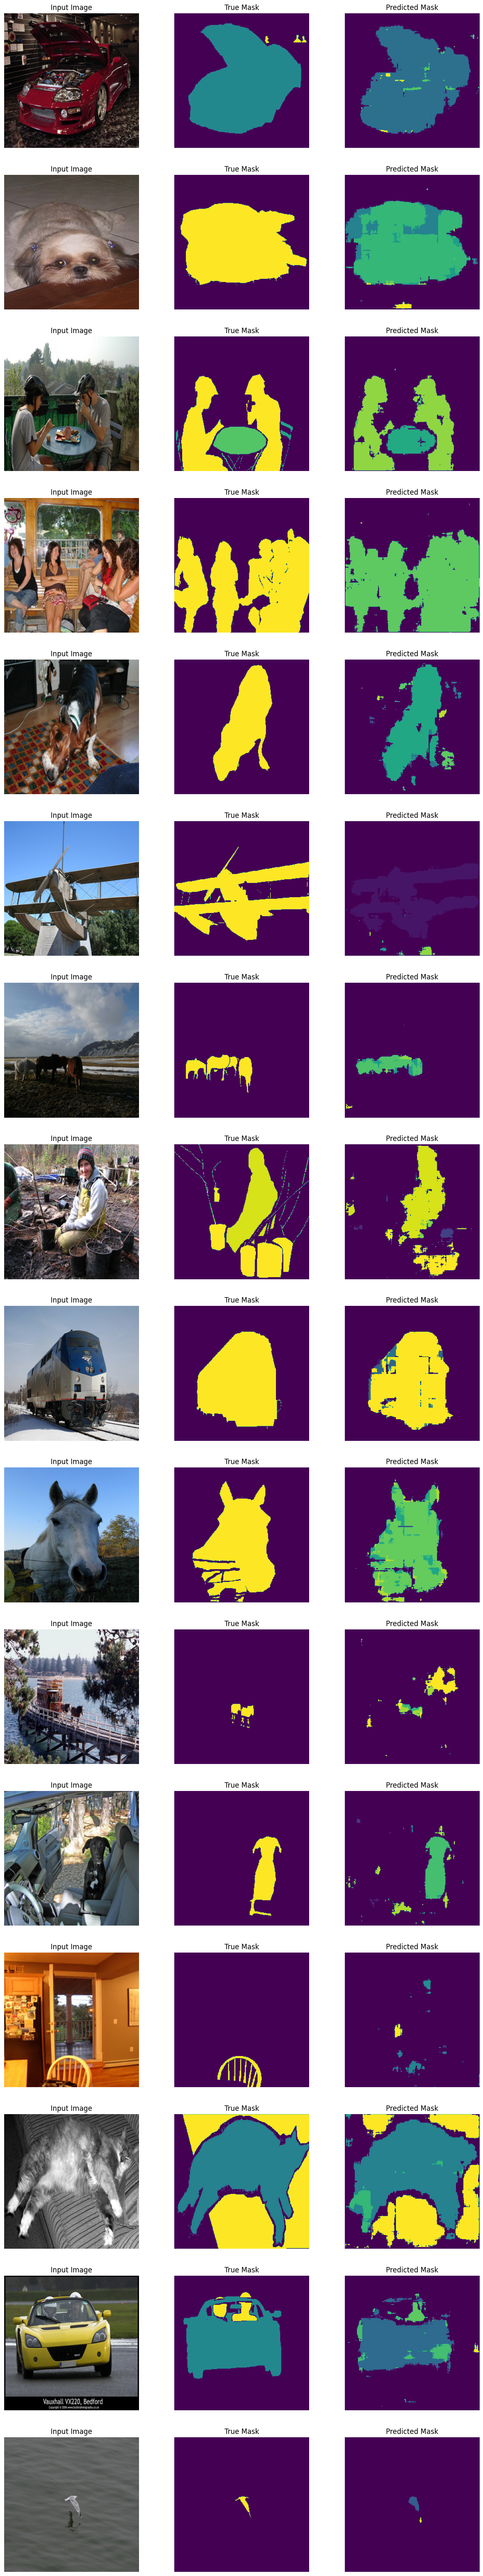

val images


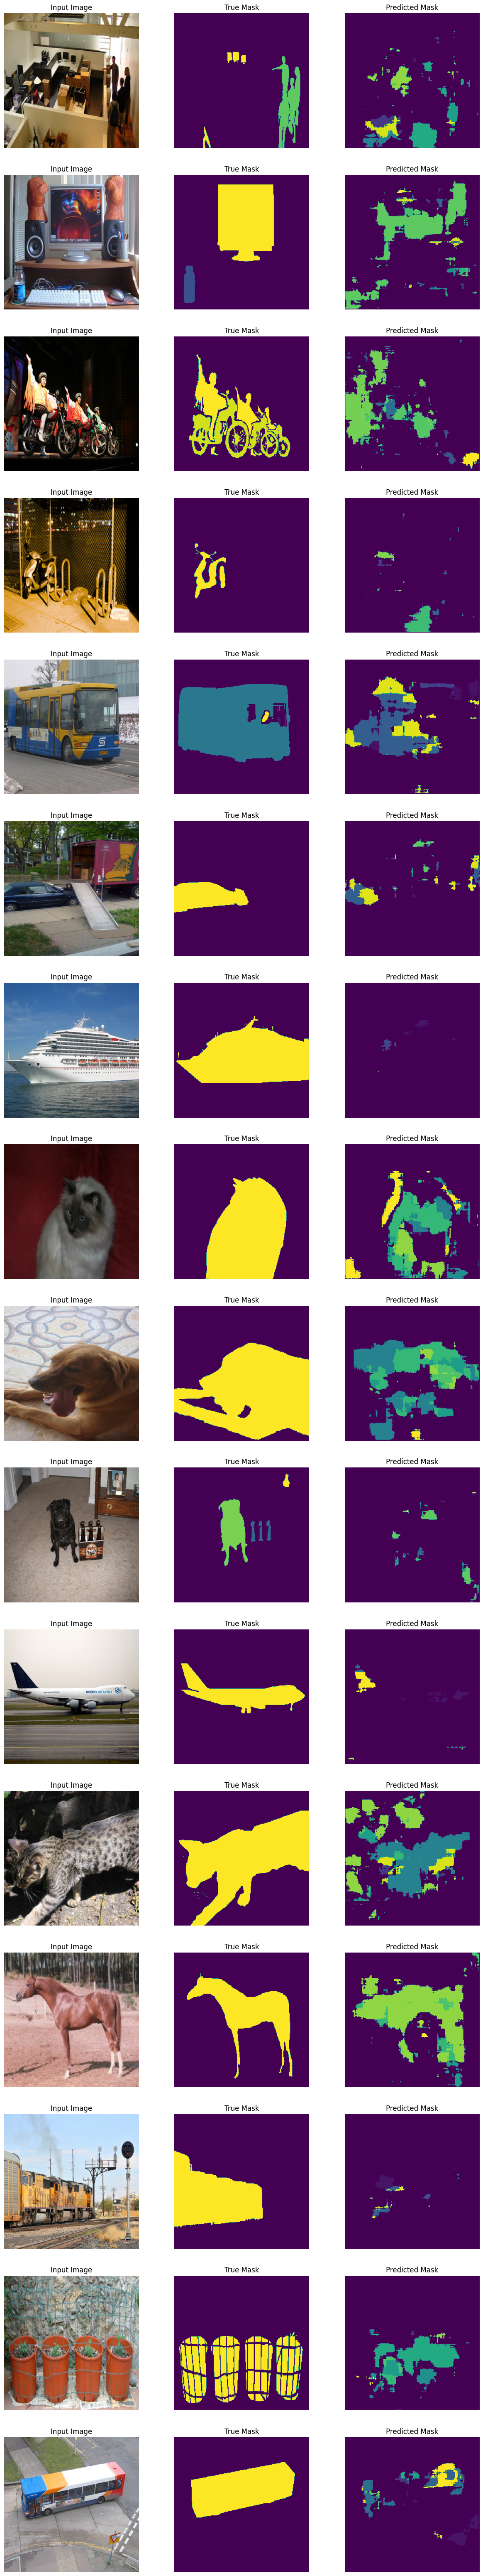

In [6]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_segmentation(images, masks, predicted_masks, num_images=3):
    plt.figure(figsize=(15, 5 * num_images))
    for i in range(num_images):
        plt.subplot(num_images, 3, i * 3 + 1)
        plt.imshow(images[i].permute(1, 2, 0))
        plt.title('Input Image')
        plt.axis('off')

        plt.subplot(num_images, 3, i * 3 + 2)
        plt.imshow(masks[i].squeeze(), cmap = 'viridis')
        plt.title('True Mask')
        plt.axis('off')

        plt.subplot(num_images, 3, i * 3 + 3)
        plt.imshow(torch.argmax(predicted_masks[i], dim=0).cpu(), cmap = 'viridis')
        plt.title('Predicted Mask')
        plt.axis('off')
    plt.show()

model.to(device)
model.eval()
with torch.no_grad():
    print("train images")
    for images, true_masks in train_loader:
        images = images.to(device)
        true_masks = true_masks.to(device).long()  
        predicted_masks = model(images)
        # Visualization
        visualize_segmentation(images.cpu(), true_masks.cpu(), predicted_masks.cpu(), num_images=16)

        break
    print("val images")
    for images, true_masks in val_loader:
        images = images.to(device)
        true_masks = true_masks.to(device).long()  
        predicted_masks = model(images)
        # Visualization
        visualize_segmentation(images.cpu(), true_masks.cpu(), predicted_masks.cpu(), num_images=16)

        break

In [13]:
torch.save(model,'segmentation/model.pth')
torch.save(model.state_dict(),'segmentation/model.statedict.pth')